In [1]:
import cv2 as cv
import mediapipe as mp
import pandas as pd
import sys
from collections import deque

In [2]:
sys.path.insert(0, '../')

In [3]:
mp_hands = mp.solutions.hands

hands = mp_hands.Hands(static_image_mode = True,
    max_num_hands = 2,
    min_detection_confidence = 0.7,
    min_tracking_confidence = 0.5
)

In [4]:
train_hands = pd.read_csv(filepath_or_buffer='_classes_train.csv',sep = ',')
test_hands = pd.read_csv(filepath_or_buffer='_classes_test.csv',sep = ',')
valid_hands = pd.read_csv(filepath_or_buffer='_classes_valid.csv',sep = ',')
train_hands = train_hands.reset_index()
test_hands = test_hands.reset_index()
valid_hands = valid_hands.reset_index()


In [5]:
from utils import landmark

def obtain_landmarks(folder,list_hands):
    df_result = pd.DataFrame()
    for index, row in list_hands.iterrows():
        image = cv.imread('./{}/{}'.format(folder,row['filename']))
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        image.flags.writeable = False
        results = hands.process(image)
        image.flags.writeable = True
        if results.multi_hand_landmarks is not None:
            for hand_landmarks,handness in zip(results.multi_hand_landmarks,
                                                results.multi_handedness):
                # Calcular Landmarks
                landmark_list = landmark.calc_landmark_list(image, hand_landmarks)
                #Convertir a cordenadas relativas / normalizada
                pre_processed_landmark_list = landmark.pre_process_landmark(
                    landmark_list)
                data_result =  list(row[2:]) + list(pre_processed_landmark_list)
                df_result = pd.concat([df_result, pd.DataFrame([data_result])], ignore_index=True)
               

    return df_result, pre_processed_landmark_list



In [6]:
training_df,pre_process_landmark_train = obtain_landmarks('train_data', train_hands)
test_df, pre_process_landmark_test = obtain_landmarks('test_data', test_hands)
valid_df, pre_process_landmark_valid = obtain_landmarks('valid_data', valid_hands)

In [7]:
def assign_names(df,list):
    column_names = (train_hands.columns[2:]).tolist()
    landmark_name = []
    for row,landmarks in enumerate(list):
        landmark_name.append('landmark_{}'.format(row))
    dataframe_columns = column_names + landmark_name
    df.columns = dataframe_columns

In [8]:
assign_names(training_df, pre_process_landmark_train)
assign_names(test_df, pre_process_landmark_test)
assign_names(valid_df, pre_process_landmark_valid)


In [9]:
training_df

,A,B,C,D,E,EYE,F,G,H,I,...,landmark_32,landmark_33,landmark_34,landmark_35,landmark_36,landmark_37,landmark_38,landmark_39,landmark_40,landmark_41
0,0,0,0,0,0,1,0,0,0,0,...,0.319410,0.378378,0.009828,0.444717,0.167076,0.474201,0.216216,0.393120,0.196560,0.329238
1,0,0,0,0,0,0,0,0,0,0,...,-0.330097,-0.461165,-0.427184,-0.257282,-0.500000,-0.417476,-0.446602,-0.402913,-0.388350,-0.364078
2,1,0,0,0,0,0,0,0,0,0,...,-0.049587,-0.520661,-0.421488,-0.644628,-0.367769,-0.818182,-0.276860,-0.570248,-0.256198,-0.500000
3,0,0,0,0,1,0,0,0,0,0,...,-0.079137,-0.820144,0.136691,-0.633094,0.129496,-0.848921,0.107914,-0.892086,0.093525,-0.791367
4,0,0,0,0,0,0,0,0,0,0,...,-0.299694,0.902141,-0.284404,0.351682,-0.314985,0.535168,-0.256881,0.516820,-0.220183,0.467890
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
770,0,0,0,0,0,0,0,0,0,0,...,0.292398,-0.619883,0.456140,-0.497076,0.608187,-0.730994,0.701754,-0.865497,0.771930,-1.000000
771,0,0,0,0,0,0,0,0,0,0,...,-0.726804,-0.067010,-0.618557,0.020619,-0.804124,0.025773,-0.742268,0.051546,-0.654639,0.051546
772,0,1,0,0,0,0,0,0,0,0,...,0.376744,-0.925581,0.334884,-0.353488,0.400000,-0.520930,0.441860,-0.632558,0.479070,-0.744186
773,0,0,0,0,0,0,0,0,0,0,...,0.276364,0.920000,0.247273,0.360000,0.283636,0.538182,0.254545,0.520000,0.210909,0.472727


In [10]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [11]:
NUM_CLASSES = 27
MODEL_PATH_SAVE = './HandClassifier/keypoint_classifier.hdf5'
TFLITE_PATH_SAVE = './HandClassifier/keypoint_classifier.tflite'

In [12]:
#Construcción del data entrenamiento X y Y
y_train = pd.DataFrame(training_df.iloc[:, :27])
X_train = pd.DataFrame(training_df.iloc[:, 27:])
y_test = pd.DataFrame(test_df.iloc[:, :27])
X_test = pd.DataFrame(test_df.iloc[:, 27:])
y_valid = pd.DataFrame(valid_df.iloc[:, :27])
X_valid = pd.DataFrame(valid_df.iloc[:, 27:])

In [13]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((42, )),
    tf.keras.layers.Dense(280, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(140, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])


In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 280)               12040     
                                                                 
 dropout (Dropout)           (None, 280)               0         
                                                                 
 dense_1 (Dense)             (None, 140)               39340     
                                                                 
 dense_2 (Dense)             (None, 27)                3807      
                                                                 
Total params: 55,187
Trainable params: 55,187
Non-trainable params: 0
_________________________________________________________________


In [15]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    MODEL_PATH_SAVE, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [16]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=tf.metrics.CategoricalAccuracy()
)

In [17]:
history = model.fit(
    X_train,
    y_train,
    epochs=70,
    batch_size=256,
    validation_data=(X_valid, y_valid),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/70
1/4 [======>.......................] - ETA: 2s - loss: 3.2382 - categorical_accuracy: 0.0430
Epoch 1: saving model to ./HandClassifier\keypoint_classifier.hdf5
4/4 [==============================] - 1s 89ms/step - loss: 3.1986 - categorical_accuracy: 0.0839 - val_loss: 3.0410 - val_categorical_accuracy: 0.2627
Epoch 2/70
1/4 [======>.......................] - ETA: 0s - loss: 3.0506 - categorical_accuracy: 0.2109
Epoch 2: saving model to ./HandClassifier\keypoint_classifier.hdf5
4/4 [==============================] - 0s 16ms/step - loss: 3.0131 - categorical_accuracy: 0.2271 - val_loss: 2.8965 - val_categorical_accuracy: 0.2396
Epoch 3/70
1/4 [======>.......................] - ETA: 0s - loss: 2.9200 - categorical_accuracy: 0.2344
Epoch 3: saving model to ./HandClassifier\keypoint_classifier.hdf5
4/4 [==============================] - 0s 17ms/step - loss: 2.8683 - categorical_accuracy: 0.2271 - val_loss: 2.7702 - val_categorical_accuracy: 0.2350
Epoch 4/70
1/4 [======>........

In [18]:
# Evaluación del modelo
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

1/1 [==============================] - 0s 22ms/step - loss: 0.7118 - categorical_accuracy: 0.8772


In [19]:
import matplotlib.pyplot as plt

history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])

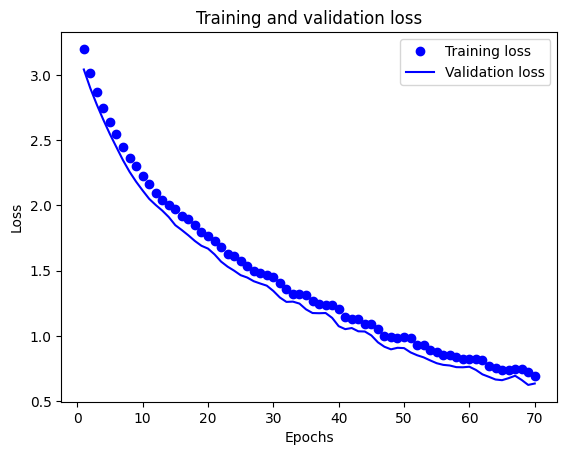

In [20]:

acc = history_dict['categorical_accuracy']
val_acc = history_dict['val_categorical_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


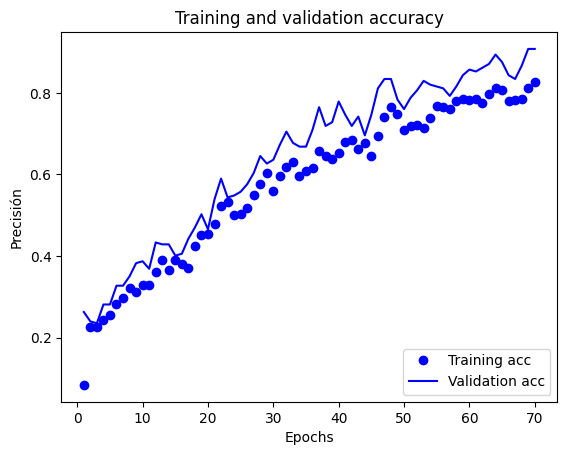

In [21]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Precisión')
plt.legend(loc='lower right')

plt.show()


In [22]:
# Loading the saved model
model = tf.keras.models.load_model(MODEL_PATH_SAVE)

In [23]:
from sklearn.metrics import classification_report
from  sklearn.metrics import precision_recall_fscore_support

def pandas_classification_report(y_true, y_pred):
    metrics_summary = precision_recall_fscore_support(
            y_true=y_true, 
            y_pred=y_pred)
    
    avg = list(precision_recall_fscore_support(
            y_true=y_true, 
            y_pred=y_pred,
            average='weighted'))

    metrics_sum_index = ['precision', 'recall', 'f1-score', 'support']
    class_report_df = pd.DataFrame(
        list(metrics_summary),
        index=metrics_sum_index)
    
    support = class_report_df.loc['support']
    total = support.sum() 
    avg[-1] = total
    
    class_report_df['avg / total'] = avg

    return class_report_df.T

4/4 [==============================] - 0s 1ms/step


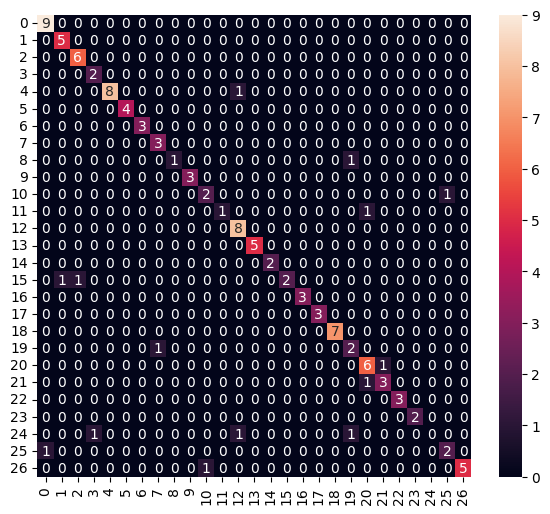

Classification Report
              precision    recall  f1-score   support

           0       0.90      1.00      0.95         9
           1       0.83      1.00      0.91         5
           2       0.86      1.00      0.92         6
           3       0.67      1.00      0.80         2
           4       1.00      0.89      0.94         9
           5       1.00      1.00      1.00         4
           6       1.00      1.00      1.00         3
           7       0.75      1.00      0.86         3
           8       1.00      0.50      0.67         2
           9       1.00      1.00      1.00         3
          10       0.67      0.67      0.67         3
          11       1.00      0.50      0.67         2
          12       0.80      1.00      0.89         8
          13       1.00      1.00      1.00         5
          14       1.00      1.00      1.00         2
          15       1.00      0.50      0.67         4
          16       1.00      1.00      1.00         3
     

c:\Users\katia\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\katia\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\katia\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [24]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_true, y_pred))

y_test_true = np.array(y_test)
Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)
y_true = np.argmax(y_test_true, axis=1)
print_confusion_matrix(y_true, y_pred)

In [25]:
# Guardar como modelo dedicado para interferencias
model.save(MODEL_PATH_SAVE, include_optimizer=False)

In [26]:
#Convertir a modelo TF-LITE

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(TFLITE_PATH_SAVE, 'wb').write(tflite_quantized_model)



INFO:tensorflow:Assets written to: C:\Users\katia\AppData\Local\Temp\tmp9wap9r1e\assets


INFO:tensorflow:Assets written to: C:\Users\katia\AppData\Local\Temp\tmp9wap9r1e\assets


58792

## Prueba de Interferencia

In [27]:
interpreter = tf.lite.Interpreter(model_path=TFLITE_PATH_SAVE)
interpreter.allocate_tensors()

In [28]:
# Obtener I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [29]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test.iloc[0]], dtype='float32'))

In [30]:
%%time
# Implementación de la interferencia
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 0 ns


In [31]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[4.7147481e-05 6.0908590e-03 9.2736232e-01 4.7010753e-06 6.1715813e-03
 5.1518105e-05 1.2916854e-03 2.3109324e-06 5.9555215e-04 1.2433334e-04
 4.3781139e-03 8.3136815e-04 6.0542612e-03 5.1568813e-06 3.2497685e-06
 3.8159873e-02 1.0483443e-05 3.5588638e-04 4.0363492e-03 2.3589848e-06
 4.6417152e-04 4.4380606e-04 1.1147864e-03 5.1985338e-04 6.4680382e-05
 3.1355777e-04 1.5001177e-03]
2
